Epoch 1/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 45s 597ms/step - accuracy: 0.8514 - loss: 0.8285 - val_accuracy: 0.8903 - val_loss: 0.5207 - learning_rate: 3.0000e-05
Epoch 2/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 597ms/step - accuracy: 0.8926 - loss: 0.4796 - val_accuracy: 0.9236 - val_loss: 0.3441 - learning_rate: 3.0000e-05
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - accuracy: 0.9186 - loss: 0.3518
Test Loss: 0.3542238771915436
Test Accuracy: 0.9162673950195312


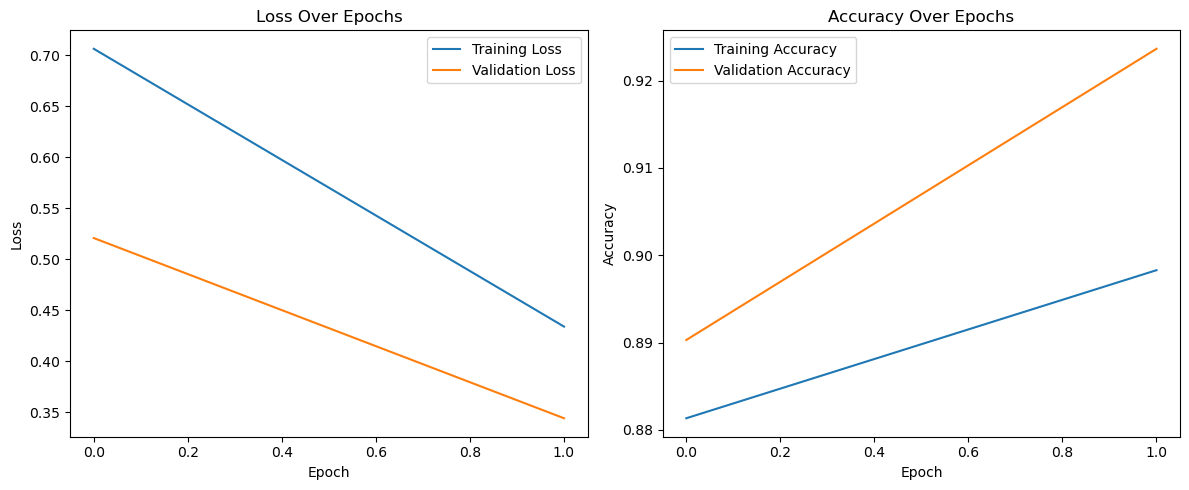

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step


IndexError: index 1 is out of bounds for axis 0 with size 1

In [9]:
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_gaussian, create_pairwise_bilateral

# 读取点云数据和标签
def load_labeled_point_cloud(file_path):
    data = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 4:
                x, y, z, label = map(float, parts)
                data.append([x, y, z])
                labels.append(int(label))
    return np.array(data), np.array(labels)

def create_voxel_grid(data, labels, grid_size):
    if data.size == 0 or labels.size == 0:
        print(f"Warning: Empty data or labels array. data.size={data.size}, labels.size={labels.size}")
        return None, None

    grid = np.zeros((grid_size, grid_size, grid_size))
    label_grid = np.zeros((grid_size, grid_size, grid_size))

    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1
        label_grid[voxel[0], voxel[1], voxel[2]] = labels[i] - 1  # Convert labels 1 and 2 to 0 and 1

    return grid, label_grid

def load_data_from_directory(data_dir, grid_size=32):
    x_data = []
    y_data = []
    for file in os.listdir(data_dir):
        if file.endswith("_labeled.txt"):
            file_path = os.path.join(data_dir, file)
            data, labels = load_labeled_point_cloud(file_path)
            if data.size == 0 or labels.size == 0:
                print(f"Skipping empty file: {file_path}")
                continue
            voxel_grid, label_grid = create_voxel_grid(data, labels, grid_size)
            if voxel_grid is not None and label_grid is not None:
                # 应用数据增强
                voxel_grid = augment_voxel_grid(voxel_grid)
                x_data.append(voxel_grid)
                y_data.append(label_grid)
    x_data = np.expand_dims(np.array(x_data), axis=-1)
    y_data = np.expand_dims(np.array(y_data), axis=-1)
    return x_data, y_data

# 数据增强
def augment_voxel_grid(voxel_grid):
    """
    对体素网格进行随机旋转和翻转。
    """
    # 随机旋转
    angle = np.random.uniform(0, 360)
    voxel_grid = np.rot90(voxel_grid, k=int(angle // 90), axes=(0, 1))
    
    # 随机翻转
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=0)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=1)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=2)
    
    return voxel_grid

# 定义UNET模型
def unet_3d(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv1)
    pool1 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool1)
    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv2)
    pool2 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool2)
    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv3)
    pool3 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Bottleneck
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool3)
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv4)

    # Decoder
    up5 = tf.keras.layers.Conv3DTranspose(256, 2, strides=(2, 2, 2), padding='same')(conv4)
    concat5 = tf.keras.layers.concatenate([up5, conv3], axis=-1)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat5)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv5)

    up6 = tf.keras.layers.Conv3DTranspose(128, 2, strides=(2, 2, 2), padding='same')(conv5)
    concat6 = tf.keras.layers.concatenate([up6, conv2], axis=-1)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat6)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv6)

    up7 = tf.keras.layers.Conv3DTranspose(64, 2, strides=(2, 2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([up7, conv1], axis=-1)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat7)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv7)

    outputs = tf.keras.layers.Conv3D(2, 1, activation='softmax')(conv7)  # 2 channels output for binary classification

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model


# 定义学习率调度函数
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1).numpy())

# 加载数据
data_dir = 'D:/BaiduSyncdisk/新建文件夹/桌面文件/深度学习程序/A-轮廓线识别/重新处理后的数据_手工筛选_0727/重新处理后的数据_手工筛选'
x_data, y_data = load_data_from_directory(data_dir, grid_size=16)

# 确保数据归一化
x_data = x_data / np.max(x_data)
y_data = y_data / np.max(y_data)

# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

# 定义模型
input_shape = (16, 16, 16, 1)
model = unet_3d(input_shape)

# 编译模型
# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


# 定义学习率调度回调和早停回调
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(
    x_train, y_train, 
    validation_split=0.1,
    epochs=2, 
    batch_size=10,
    callbacks=[lr_scheduler, early_stopping]
)

# 评估模型
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 绘制训练过程中的损失和精确度
def plot_training_history(history):
    """
    绘制训练过程中的损失和精确度。
    """
    # 绘制损失
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # 绘制精确度
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 绘制训练历史
plot_training_history(history)

# 使用 CRF 后处理
def apply_crf(voxel_grid, probs):
    grid_size = voxel_grid.shape[0]
    num_voxels = grid_size * grid_size * grid_size

    # 创建 DenseCRF 对象
    d = dcrf.DenseCRF(num_voxels, 2)

    # 创建 Unary 能量
    probs = np.stack([1 - probs, probs], axis=0)  # Create the correct shape for probabilities
    probs = np.ascontiguousarray(probs.reshape((2, num_voxels)))  # Reshape probabilities to (2, N)
    U = unary_from_softmax(probs)
    d.setUnaryEnergy(U)

    # 增加高斯对势能（基于位置的光滑项）
    pairwise_gaussian = create_pairwise_gaussian(sdims=(3, 3, 3), shape=(grid_size, grid_size, grid_size))
    d.addPairwiseEnergy(pairwise_gaussian, compat=3)

    # 增加双边对势能（基于颜色和位置的光滑项）
    voxel_grid = np.ascontiguousarray(voxel_grid.reshape(-1, 1))  # Reshape voxel grid
    pairwise_bilateral = create_pairwise_bilateral(sdims=(3, 3, 3), schan=(1,), img=voxel_grid, chdim=1)
    d.addPairwiseEnergy(pairwise_bilateral, compat=10)

    # 进行推理
    Q = d.inference(5)

    # 获得分割结果
    result = np.argmax(Q, axis=0).reshape((grid_size, grid_size, grid_size))

    return result



# 获取模型预测
y_pred_probs = model.predict(x_test)

# 应用 CRF 后处理
y_pred_crf = []
for i in range(y_pred_probs.shape[0]):
    probs = y_pred_probs[i]
    probs = probs[..., 1]  # Select the foreground probability
    y_pred_crf.append(apply_crf(x_test[i, ..., 0], probs))

y_pred_crf = np.array(y_pred_crf)

# 评估 CRF 后处理后的结果
test_loss_crf, test_accuracy_crf = model.evaluate(y_pred_crf[..., np.newaxis], y_test)

print(f"Test Loss after CRF: {test_loss_crf}")
print(f"Test Accuracy after CRF: {test_accuracy_crf}")


def visualize_results(x_test, y_test, y_pred, y_pred_crf, index):
    """
    可视化分割结果，包括原始体素网格、初始分割结果和 CRF 后处理结果。
    """
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    # 原始体素网格
    axs[0, 0].imshow(x_test[index, :, :, 8, 0], cmap='gray')
    axs[0, 0].set_title('Original Voxel Grid (Slice 8)')
    
    # Ground Truth
    axs[0, 1].imshow(y_test[index, :, :, 8, 0], cmap='jet')
    axs[0, 1].set_title('Ground Truth (Slice 8)')

    # Initial U-Net Segmentation
    axs[0, 2].imshow(np.argmax(y_pred[index, :, :, 8], axis=-1), cmap='jet')
    axs[0, 2].set_title('U-Net Segmentation (Slice 8)')

    # CRF Post-Processing
    axs[0, 3].imshow(y_pred_crf[index, :, :, 8], cmap='jet')
    axs[0, 3].set_title('CRF Post-Processing (Slice 8)')

    # Visualize another slice (e.g., slice 4)
    axs[1, 0].imshow(x_test[index, :, :, 4, 0], cmap='gray')
    axs[1, 0].set_title('Original Voxel Grid (Slice 4)')
    
    axs[1, 1].imshow(y_test[index, :, :, 4, 0], cmap='jet')
    axs[1, 1].set_title('Ground Truth (Slice 4)')

    axs[1, 2].imshow(np.argmax(y_pred[index, :, :, 4], axis=-1), cmap='jet')
    axs[1, 2].set_title('U-Net Segmentation (Slice 4)')

    axs[1, 3].imshow(y_pred_crf[index, :, :, 4], cmap='jet')
    axs[1, 3].set_title('CRF Post-Processing (Slice 4)')

    plt.tight_layout()
    plt.show()

# 可视化一个示例的分割结果
visualize_results(x_test, y_test, y_pred_probs, y_pred_crf, index=0)




In [15]:
def apply_crf(voxel_grid, probs):
    grid_size = voxel_grid.shape[0]
    num_voxels = grid_size * grid_size * grid_size

    # 创建 DenseCRF 对象
    d = dcrf.DenseCRF(num_voxels, 2)

    # 创建 Unary 能量
    probs = np.stack([1 - probs, probs], axis=0)  # Create the correct shape for probabilities
    probs = np.ascontiguousarray(probs.reshape((2, num_voxels)))  # Reshape probabilities to (2, N)
    U = unary_from_softmax(probs)
    d.setUnaryEnergy(U)

    # 增加高斯对势能（基于位置的光滑项）
    pairwise_gaussian = create_pairwise_gaussian(sdims=(3, 3, 3), shape=(grid_size, grid_size, grid_size))
    d.addPairwiseEnergy(pairwise_gaussian, compat=3)

    # 增加双边对势能（基于颜色和位置的光滑项）
    voxel_grid = np.ascontiguousarray(voxel_grid.reshape(-1, 1))  # Reshape voxel grid
    pairwise_bilateral = create_pairwise_bilateral(sdims=(3, 3, 3), schan=(1,), img=voxel_grid, chdim=1)
    d.addPairwiseEnergy(pairwise_bilateral, compat=10)

    # 进行推理
    Q = d.inference(5)

    # 获得分割结果
    result = np.argmax(Q, axis=0).reshape((grid_size, grid_size, grid_size))

    return result



In [17]:
# 获取模型预测
y_pred_probs = model.predict(x_test)

# 打印形状信息进行调试
print("Shape of x_test:", x_test.shape)
print("Shape of y_pred_probs:", y_pred_probs.shape)

# 应用 CRF 后处理
y_pred_crf = []
for i in range(y_pred_probs.shape[0]):
    probs = y_pred_probs[i]
    if probs.shape[-1] == 2:
        probs = probs[..., 1]  # Select the foreground probability
    else:
        raise ValueError(f"Unexpected shape for probs: {probs.shape}")
    y_pred_crf.append(apply_crf(x_test[i, ..., 0], probs))

y_pred_crf = np.array(y_pred_crf)

# 打印形状信息进行调试
print("Shape of y_pred_crf:", y_pred_crf.shape)
print("Shape of y_test:", y_test.shape)

# 评估 CRF 后处理后的结果
test_loss_crf, test_accuracy_crf = model.evaluate(y_pred_crf[..., np.newaxis], y_test)

print(f"Test Loss after CRF: {test_loss_crf}")
print(f"Test Accuracy after CRF: {test_accuracy_crf}")



6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step
Shape of x_test: (192, 16, 16, 16, 1)
Shape of y_pred_probs: (192, 16, 16, 16, 2)


IndexError: index 1 is out of bounds for axis 0 with size 1

Epoch 1/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 46s 609ms/step - accuracy: 0.7542 - loss: 0.8477 - val_accuracy: 0.8903 - val_loss: 0.5201 - learning_rate: 3.0000e-05
Epoch 2/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 42s 612ms/step - accuracy: 0.8941 - loss: 0.4794 - val_accuracy: 0.9262 - val_loss: 0.3461 - learning_rate: 3.0000e-05
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.9211 - loss: 0.3530
Test Loss: 0.35505175590515137
Test Accuracy: 0.9192950129508972


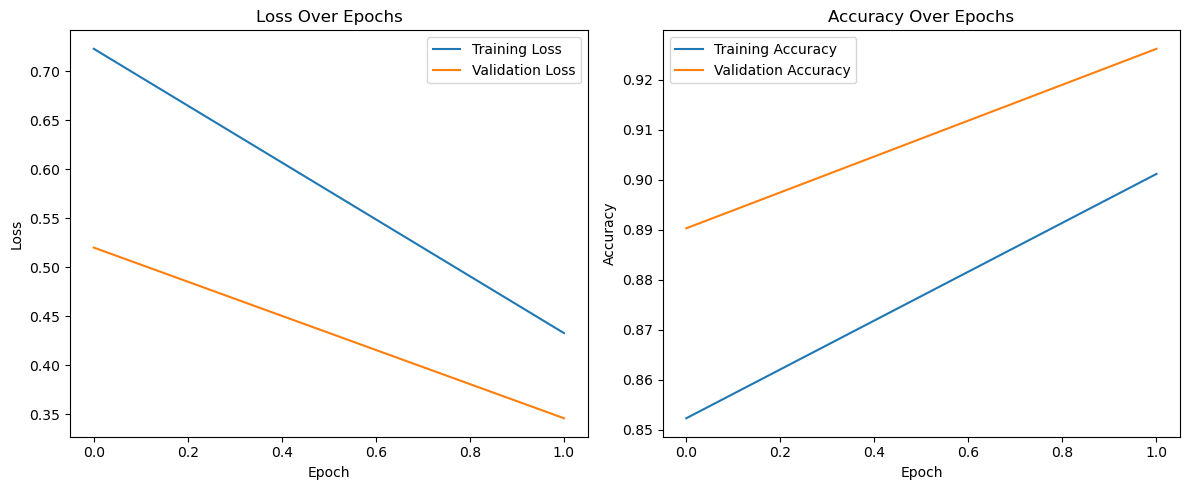

In [21]:
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_gaussian, create_pairwise_bilateral

# 读取点云数据和标签
def load_labeled_point_cloud(file_path):
    data = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 4:
                x, y, z, label = map(float, parts)
                data.append([x, y, z])
                labels.append(int(label))
    return np.array(data), np.array(labels)

def create_voxel_grid(data, labels, grid_size):
    if data.size == 0 or labels.size == 0:
        print(f"Warning: Empty data or labels array. data.size={data.size}, labels.size={labels.size}")
        return None, None

    grid = np.zeros((grid_size, grid_size, grid_size))
    label_grid = np.zeros((grid_size, grid_size, grid_size))

    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1
        label_grid[voxel[0], voxel[1], voxel[2]] = labels[i] - 1  # Convert labels 1 and 2 to 0 and 1

    return grid, label_grid

def load_data_from_directory(data_dir, grid_size=32):
    x_data = []
    y_data = []
    for file in os.listdir(data_dir):
        if file.endswith("_labeled.txt"):
            file_path = os.path.join(data_dir, file)
            data, labels = load_labeled_point_cloud(file_path)
            if data.size == 0 or labels.size == 0:
                print(f"Skipping empty file: {file_path}")
                continue
            voxel_grid, label_grid = create_voxel_grid(data, labels, grid_size)
            if voxel_grid is not None and label_grid is not None:
                # 应用数据增强
                voxel_grid = augment_voxel_grid(voxel_grid)
                x_data.append(voxel_grid)
                y_data.append(label_grid)
    x_data = np.expand_dims(np.array(x_data), axis=-1)
    y_data = np.expand_dims(np.array(y_data), axis=-1)
    return x_data, y_data

# 数据增强
def augment_voxel_grid(voxel_grid):
    """
    对体素网格进行随机旋转和翻转。
    """
    # 随机旋转
    angle = np.random.uniform(0, 360)
    voxel_grid = np.rot90(voxel_grid, k=int(angle // 90), axes=(0, 1))
    
    # 随机翻转
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=0)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=1)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=2)
    
    return voxel_grid

# 定义UNET模型
def unet_3d(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv1)
    pool1 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool1)
    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv2)
    pool2 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool2)
    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv3)
    pool3 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Bottleneck
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool3)
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv4)

    # Decoder
    up5 = tf.keras.layers.Conv3DTranspose(256, 2, strides=(2, 2, 2), padding='same')(conv4)
    concat5 = tf.keras.layers.concatenate([up5, conv3], axis=-1)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat5)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv5)

    up6 = tf.keras.layers.Conv3DTranspose(128, 2, strides=(2, 2, 2), padding='same')(conv5)
    concat6 = tf.keras.layers.concatenate([up6, conv2], axis=-1)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat6)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv6)

    up7 = tf.keras.layers.Conv3DTranspose(64, 2, strides=(2, 2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([up7, conv1], axis=-1)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat7)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv7)

    outputs = tf.keras.layers.Conv3D(2, 1, activation='softmax')(conv7)  # 2 channels output for binary classification

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

# 定义学习率调度函数
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1).numpy())

# 加载数据
data_dir = 'D:/BaiduSyncdisk/新建文件夹/桌面文件/深度学习程序/A-轮廓线识别/重新处理后的数据_手工筛选_0727/重新处理后的数据_手工筛选'
x_data, y_data = load_data_from_directory(data_dir, grid_size=16)

# 确保数据归一化
x_data = x_data / np.max(x_data)
y_data = y_data / np.max(y_data)

# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

# 定义模型
input_shape = (16, 16, 16, 1)
model = unet_3d(input_shape)

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# 定义学习率调度回调和早停回调
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(
    x_train, y_train, 
    validation_split=0.1,
    epochs=2, 
    batch_size=10,
    callbacks=[lr_scheduler, early_stopping]
)

# 评估模型
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 绘制训练过程中的损失和精确度
def plot_training_history(history):
    """
    绘制训练过程中的损失和精确度。
    """
    # 绘制损失
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # 绘制精确度
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 绘制训练历史
plot_training_history(history)

In [31]:
def apply_crf(voxel_grid, probs):
    grid_size = voxel_grid.shape[0]
    num_voxels = grid_size * grid_size * grid_size

    print(f"Shape of voxel_grid: {voxel_grid.shape}")
    print(f"Shape of probs before stack: {probs.shape}")

    # 创建 DenseCRF 对象
    d = dcrf.DenseCRF(num_voxels, 2)

    # 创建 Unary 能量
    # Here, we need to ensure the probabilities are correctly stacked and reshaped
    probs = np.stack([1 - probs, probs], axis=0)  # Create the correct shape for probabilities
    print(f"Shape of probs after stack: {probs.shape}")

    # Check if the array is C-contiguous, if not, make it contiguous
    if not probs.flags['C_CONTIGUOUS']:
        probs = np.ascontiguousarray(probs)
    
    probs = probs.reshape((2, num_voxels))  # Reshape probabilities to (2, N)
    print(f"Shape of probs after reshape: {probs.shape}")

    U = unary_from_softmax(probs)
    d.setUnaryEnergy(U)

    # 增加高斯对势能（基于位置的光滑项）
    pairwise_gaussian = create_pairwise_gaussian(sdims=(3, 3, 3), shape=(grid_size, grid_size, grid_size))
    d.addPairwiseEnergy(pairwise_gaussian, compat=3)

    # 增加双边对势能（基于颜色和位置的光滑项）
    voxel_grid = voxel_grid.reshape(-1, 1)  # Reshape voxel grid
    pairwise_bilateral = create_pairwise_bilateral(sdims=(3, 3, 3), schan=(1,), img=voxel_grid, chdim=1)
    d.addPairwiseEnergy(pairwise_bilateral, compat=10)

    # 进行推理
    Q = d.inference(5)

    # 获得分割结果
    result = np.argmax(Q, axis=0).reshape((grid_size, grid_size, grid_size))

    return result


In [33]:
# 获取模型预测
y_pred_probs = model.predict(x_test)

# 打印形状信息进行调试
print("Shape of x_test:", x_test.shape)
print("Shape of y_pred_probs:", y_pred_probs.shape)

# 应用 CRF 后处理
y_pred_crf = []
for i in range(y_pred_probs.shape[0]):
    probs = y_pred_probs[i]
    print(f"Shape of probs: {probs.shape}")
    if probs.shape[-1] == 2:
        probs = probs[..., 1]  # Select the foreground probability
        print(f"Shape of probs after selecting foreground: {probs.shape}")
    else:
        raise ValueError(f"Unexpected shape for probs: {probs.shape}")
    y_pred_crf.append(apply_crf(x_test[i, ..., 0], probs))

y_pred_crf = np.array(y_pred_crf)

# 打印形状信息进行调试
print("Shape of y_pred_crf:", y_pred_crf.shape)
print("Shape of y_test:", y_test.shape)

# 评估 CRF 后处理后的结果
test_loss_crf, test_accuracy_crf = model.evaluate(y_pred_crf[..., np.newaxis], y_test)

print(f"Test Loss after CRF: {test_loss_crf}")
print(f"Test Accuracy after CRF: {test_accuracy_crf}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step
Shape of x_test: (192, 16, 16, 16, 1)
Shape of y_pred_probs: (192, 16, 16, 16, 2)
Shape of probs: (16, 16, 16, 2)
Shape of probs after selecting foreground: (16, 16, 16)
Shape of voxel_grid: (16, 16, 16)
Shape of probs before stack: (16, 16, 16)
Shape of probs after stack: (2, 16, 16, 16)
Shape of probs after reshape: (2, 4096)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [29]:
def visualize_results(x_test, y_test, y_pred, y_pred_crf, index):
    """
    可视化分割结果，包括原始体素网格、初始分割结果和 CRF 后处理结果。
    """
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    # 原始体素网格
    axs[0, 0].imshow(x_test[index, :, :, 8, 0], cmap='gray')
    axs[0, 0].set_title('Original Voxel Grid (Slice 8)')
    
    # Ground Truth
    axs[0, 1].imshow(y_test[index, :, :, 8, 0], cmap='jet')
    axs[0, 1].set_title('Ground Truth (Slice 8)')

    # Initial U-Net Segmentation
    axs[0, 2].imshow(np.argmax(y_pred[index, :, :, 8], axis=-1), cmap='jet')
    axs[0, 2].set_title('U-Net Segmentation (Slice 8)')

    # CRF Post-Processing
    axs[0, 3].imshow(y_pred_crf[index, :, :, 8], cmap='jet')
    axs[0, 3].set_title('CRF Post-Processing (Slice 8)')

    # Visualize another slice (e.g., slice 4)
    axs[1, 0].imshow(x_test[index, :, :, 4, 0], cmap='gray')
    axs[1, 0].set_title('Original Voxel Grid (Slice 4)')
    
    axs[1, 1].imshow(y_test[index, :, :, 4, 0], cmap='jet')
    axs[1, 1].set_title('Ground Truth (Slice 4)')

    axs[1, 2].imshow(np.argmax(y_pred[index, :, :, 4], axis=-1), cmap='jet')
    axs[1, 2].set_title('U-Net Segmentation (Slice 4)')

    axs[1, 3].imshow(y_pred_crf[index, :, :, 4], cmap='jet')
    axs[1, 3].set_title('CRF Post-Processing (Slice 4)')

    plt.tight_layout()
    plt.show()

# 可视化一个示例的分割结果
visualize_results(x_test, y_test, y_pred_probs, y_pred_crf, index=0)



6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step
Shape of x_test: (192, 16, 16, 16, 1)
Shape of y_pred_probs: (192, 16, 16, 16, 2)
Shape of probs: (16, 16, 16, 2)
Shape of probs after selecting foreground: (16, 16, 16)
Shape of voxel_grid: (16, 16, 16)
Shape of probs before stack: (16, 16, 16)
Shape of probs after stack: (2, 16, 16, 16)
Shape of probs after reshape: (2, 4096)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
# 评估 CRF 后处理后的结果
test_loss_crf, test_accuracy_crf = model.evaluate(y_pred_crf[..., np.newaxis], y_test)

print(f"Test Loss after CRF: {test_loss_crf}")
print(f"Test Accuracy after CRF: {test_accuracy_crf}")